<a href="https://colab.research.google.com/github/ddinesan/Manga/blob/master/Lecture_20_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a worksheet prepared by Kai Wang and Dominic Fluet for Lecture 20 of the reading course "Introduction to Quantum Computer Programming" (AMATH 900/ AMATH 495/ QIC 895) at the University of Waterloo.

Course Webpage: https://sites.google.com/view/quantum-computer-programming

Text followed in the course: [Quantum Computing, An Applied Approach](https://www.springer.com/gp/book/9783030239213) by Jack D. Hidary (2019)


#Quantum Approximate Optimization Algorithm (QAOA)
QAOA of the Ising model

In [ ]:
# Imports
!pip install cirq
import numpy as np
import matplotlib.pyplot as plt
import cirq

from cirq.contrib.svg import circuit_to_svg
from IPython.display import SVG, display
import os

def cprint(circuit):
  """Convert the cirq.Circuit to a temp svg and display + garbage collect."""
  with open("temp.svg", 'w+') as f:
    f.write(circuit_to_svg(circuit))
  display(SVG('temp.svg'))
  os.remove('temp.svg')

We write a function which gives us a circuit for
implementing the unitary $e^{i\pi\gamma Z_i Z_j}$. We then test our function by printing out the circuit for an example set of qubits $i$ and $j$ with an arbitrary value of $\gamma$ and ensuring that the unitary matrix of this circuit is what we expect.

In [ ]:
# Function to implement a ZZ gate on qubits a, b with angle gamma
def ZZ(a, b, gamma):
  """Returns a circuit implementing exp(-i \pi \gamma Z_i Z_j)."""
  # Get a circuit
  circuit = cirq.Circuit()
  # Gives the fourth diagonal component
  circuit.append(cirq.CZ(a, b)**gamma)
  # Gives the third diagonal component
  circuit.append([cirq.X(b), cirq.CZ(a,b)**(-1 * gamma), cirq.X(b)])
  # Gives the second diagonal component
  circuit.append([cirq.X(a), cirq.CZ(a,b)**-gamma, cirq.X(a)])
  # Gives the first diagonal component
  circuit.append([cirq.X(a), cirq.X(b), cirq.CZ(a,b)**gamma,
  cirq.X(a), cirq.X(b)])
  return circuit

$\gamma=0.5$

$e^{i\pi0.5}=i$

$e^{-i\pi0.5}=-i$

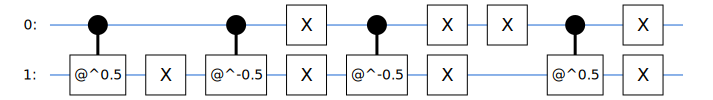


Unitary of circuit:
[[0.+1.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.-1.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.-1.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+1.j]]


In [ ]:
# Make sure the circuit gives the correct matrix
qreg = cirq.LineQubit.range(2)
zzcirc = ZZ(qreg[0], qreg[1], 0.5)
#print("Circuit for ZZ gate:", zzcirc, sep="\n")
cprint(cirq.Circuit(*zzcirc))
print("\nUnitary of circuit:", zzcirc.unitary().round(2), sep="\n")

We can see that this circuit indeed implements the
desired unitary operator. 

In the next block of code, we define a 2x2 grid of qubits.

In [ ]:
ncols = 2
nrows = 2
qreg = [[cirq.GridQubit(i,j) for j in range(ncols)] for i in range(nrows)]

Then we write functions for implementing the operators $U(H_C,\gamma)$ and $U(H_B,\beta)$.

In [ ]:
# Function to implement the cost Hamiltonian
def cost_circuit(gamma):
  """Returns a circuit for the cost Hamiltonian."""
  circ = cirq.Circuit()
  for i in range(nrows):
    for j in range(ncols):
      if i < nrows - 1:
        circ += ZZ(qreg[i][j], qreg[i + 1][j], gamma)
      if j < ncols - 1:
        circ += ZZ(qreg[i][j], qreg[i][j + 1], gamma)
  return circ
# Function to implement the mixer Hamiltonian
def mixer(beta):
  """Generator for U(H_B, beta) layer (mixing layer)"""
  for row in qreg:
    for qubit in row:
      yield cirq.X(qubit)**beta

These functions allow us to construct the entire QAOA circuit. The function below builds this circuit for an arbitrary number $p$ of parameters.

In [ ]:
# Function to build the QAOA circuit
def qaoa(gammas, betas):
  """Returns a QAOA circuit."""
  circ = cirq.Circuit()
  circ.append(cirq.H.on_each(*[q for row in qreg for q in row]))
  for i in range(len(gammas)):
    circ += cost_circuit(gammas[i])
    circ.append(mixer(betas[i]))
  return circ

Now that we can build our QAOA circuit for a given set of parameters, we
can compute the expectation of the cost Hamiltonian in the final state.
For simplicity we use Cirq’s ability to access the wavefunction to compute
this expectation rather than sampling from the circuit itself. The following
function shows how we can access the wavefunction after applying a circuit:

In [ ]:
def simulate(circ):
  """Returns the wavefunction after applying the circuit."""
  sim = cirq.Simulator()
  return sim.simulate(circ).final_state

The next function evaluates the expectation using the wavefunction:

In [ ]:
def energy_from_wavefunction(wf):
  """Computes the energy-per-site of the Ising Model from the wavefunction."""
  # Z is a (n_sites x 2**n_sites) array. Each row consists of the
  # 2**n_sites non-zero entries in the operator that is the Pauli-Z matrix on
  # one of the qubits times the identites on the other qubits.
  # The (i*n_cols + j)th row corresponds to qubit (i,j).
  nsites = 4
  Z = np.array([(-1)**(np.arange(2**nsites) >> i)
    for i in range(nsites-1,-1,-1)])
  # Create the operator corresponding to the interaction energy summed over all
  # nearest-neighbor pairs of qubits
  ZZ_filter = np.zeros_like(wf, dtype=float)
  for i in range(nrows):
    for j in range(ncols):
      if i < nrows-1:
        ZZ_filter += Z[i*ncols + j]*Z[(i+1)*ncols + j]
      if j < ncols-1:
        ZZ_filter += Z[i*ncols + j]*Z[i*ncols + (j+1)]
  # Expectation value of the energy divided by the number of sites
  return -np.sum(np.abs(wf)**2 * ZZ_filter) / nsites

Finally, for convenience, we define a function that computes the energy/cost directly from a set of parameters. This function uses the parameters to
build a circuit, then gets the wavefunction of the final state and lastly computes the energy/cost using the previous function.

In [ ]:
def cost(gammas, betas):
  """Returns the cost function of the problem."""
  wavefunction = simulate(qaoa(gammas, betas))
  return energy_from_wavefunction(wavefunction)

These functions provide the set up for QAOA, and we could now optimize the
parameters to minimize the cost. For instructional purposes, we implement
QAOA with $p=1$ layers and perform a grid search, plotting the 2D cost
landscape for each parameter $\gamma$ and $\beta$. The function for the grid search over a range of parameters is given below:

In [ ]:
def grid_search(gammavals, betavals):
  """Does a grid search over all parameter values."""
  costmat = np.zeros((len(gammavals), len(betavals)))
  for (i, gamma) in enumerate(gammavals):
    for (j, beta) in enumerate(betavals):
      costmat[i, j] = cost([gamma], [beta])
  return costmat

Finally, here is the code for using this function within the main script and
plotting the cost landscape:

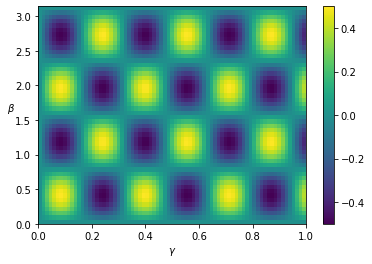

In [ ]:
# Get a range of parameters
gammavals = np.linspace(0, 1.0, 50)
betavals = np.linspace(0, np.pi, 75)
# Compute the cost at all parameter values using a grid search
costmat = grid_search(gammavals, betavals)
# Plot the cost landscape
plt.imshow(costmat, extent=(0, 1, 0, np.pi), origin="lower", aspect="auto")
plt.colorbar()
plt.xlabel(r"$\gamma$")
plt.ylabel(r"$\beta$", rotation=0)
plt.show()

We can now obtain a set of optimal parameters by taking the coordinates
of a minimum in our cost landscape. The following short block of code does
this and prints out the numerical value of the cost at these parameters.

In [ ]:
# Coordinates from the grid of cost values
gamma_coord, beta_coord = np.where(costmat == np.min(costmat))
# Values from the coordinates
gamma_opt = gammavals[gamma_coord[0]]
beta_opt = betavals[beta_coord[0]]
print("Optimal gamma:")
print(gamma_opt)
print("\nOptimal beta:")
print(beta_opt)
print("\nMinimum cost")
print(np.min(costmat))

Optimal gamma:
0.8775510204081632

Optimal beta:
2.2500596032467435

Minimum cost
-0.4997431207448244


Now that we have the optimal parameters, we can run the QAOA circuit with
these parameters and measure in the computational basis to get bitstrings that
solve our original optimization problem. The function below runs the circuit
and returns the measurement results.

In [ ]:
def get_bit_strings(gammas, betas, nreps=10000):
  """Measures the QAOA circuit in the computational basis to get bitstrings."""
  circ = qaoa(gammas, betas)
  circ.append(cirq.measure(*[qubit for row in qreg for qubit in row], key='m'))
  # Simulate the circuit
  sim = cirq.Simulator()
  res = sim.run(circ, repetitions=nreps)
  return res

Finally, we use this function to sample from the circuit at the optimal parameters found above. Then, we parse the output and print out the two most
common bitstrings sampled from the circuit.

In [ ]:
# Sample to get bits and convert to a histogram
bits = get_bit_strings([gamma_opt], [beta_opt])
hist = bits.histogram(key="m")
# Get the most common bits
top = hist.most_common(16)
# Print out the most common bitstrings measured
print("Most common bitstring:")
print(format(top[0][0], 'b').zfill(4))
print("\nSecond most common bitstring:")
print(format(top[1][0], 'b').zfill(4))
print("\nMost common to least common:")
order=[]
for el in top:
  el = list(el)
  el[0]=format(el[0], 'b').zfill(4)
  order.append(el)
print(order)

Most common bitstring:
1111

Second most common bitstring:
0000

Most common to least common:
[['1111', 2658], ['0000', 2640], ['1010', 788], ['0011', 770], ['0101', 754], ['1100', 722], ['1101', 195], ['0111', 190], ['0010', 180], ['0001', 174], ['0100', 161], ['1000', 160], ['1110', 159], ['1011', 152], ['0110', 152], ['1001', 145]]


#References

1.   Jack D. Hidary, "*Quantum Computing: An Applied Approach*", 2019

